# Prophet Forecasting - Weekdays, Weekends, and Bank Holidays

This notebook demonstrates a simple implementation of using Prophet to forecast gym busyness on a sub-daily timescale, accounting for the notable difference in dailys trends between weekdays vs weekends/bank holidays.

Data is used from TheGym's Angel gym branch, scraped every 15 minutes between 2021-04-25 and 2022-01-22 (with incomplete time periods).

## Set-up

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from prophet import Prophet

from src.features.processing import load_gym_data
from src.utils import get_project_root
from src.visualisation.plotting import plot_24h

In [2]:
ROOT_DIR = get_project_root()
plt.style.use(ROOT_DIR / "style.mplstyle")

In [3]:
uk_bank_holidays = [
    "2021-01-01",
    "2021-04-02",
    "2021-04-05",
    "2021-05-03",
    "2021-05-31",
    "2021-08-30",
    "2021-12-25",
    "2021-12-26",
    "2021-12-27",
    "2021-12-28",
    "2022-01-03",
    "2022-04-15",
    "2022-04-18",
    "2022-05-02",
    "2022-06-02",
    "2022-06-03",
    "2022-08-29",
    "2022-12-25",
    "2022-12-26",
    "2022-12-27",
]

## Prepare and Visualise Data

### Load Data

In [4]:
df = load_gym_data()
print(df["time"].min(), df["time"].max())
df.sample(10)

2021-04-25 18:15:00 2022-01-22 14:15:00


,time,name,capacity
8901,2021-07-29 09:00:00,London Angel,17.0
2178,2021-05-18 18:00:00,London Angel,62.0
3892,2021-06-06 07:15:00,London Angel,6.0
16646,2021-10-19 08:30:00,London Angel,36.0
7625,2021-07-15 18:45:00,London Angel,61.0
17918,2021-11-02 04:45:00,London Angel,6.0
14805,2021-09-29 14:45:00,London Angel,27.0
9768,2021-08-07 12:00:00,London Angel,20.0
520,2021-05-01 05:15:00,London Angel,2.0
1652,2021-05-13 06:00:00,London Angel,20.0


### Examine 24h Plots

The average 24h plot for the entire time period masks the differences seen for different days of the week.

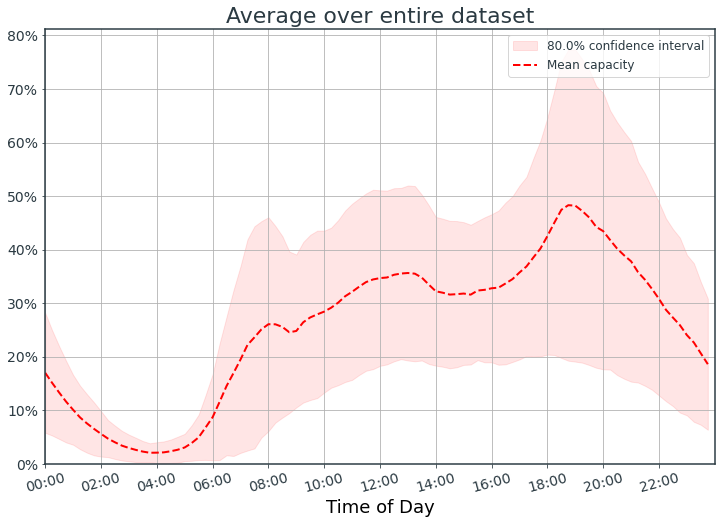

In [5]:
fig, ax = plt.subplots()
plot_24h(df, conf_interval=0.8, ax=ax)
ax.set_title(f"Average over entire dataset")
fig

The 24h plots for Mon-Fri show a similar pattern, with capacity mostly flat between 07:00-16:00 before peaking at around 19:00. Weekends show a different, flatter pattern, that peaks around midday before gently decreasing throughout the rest of the day.

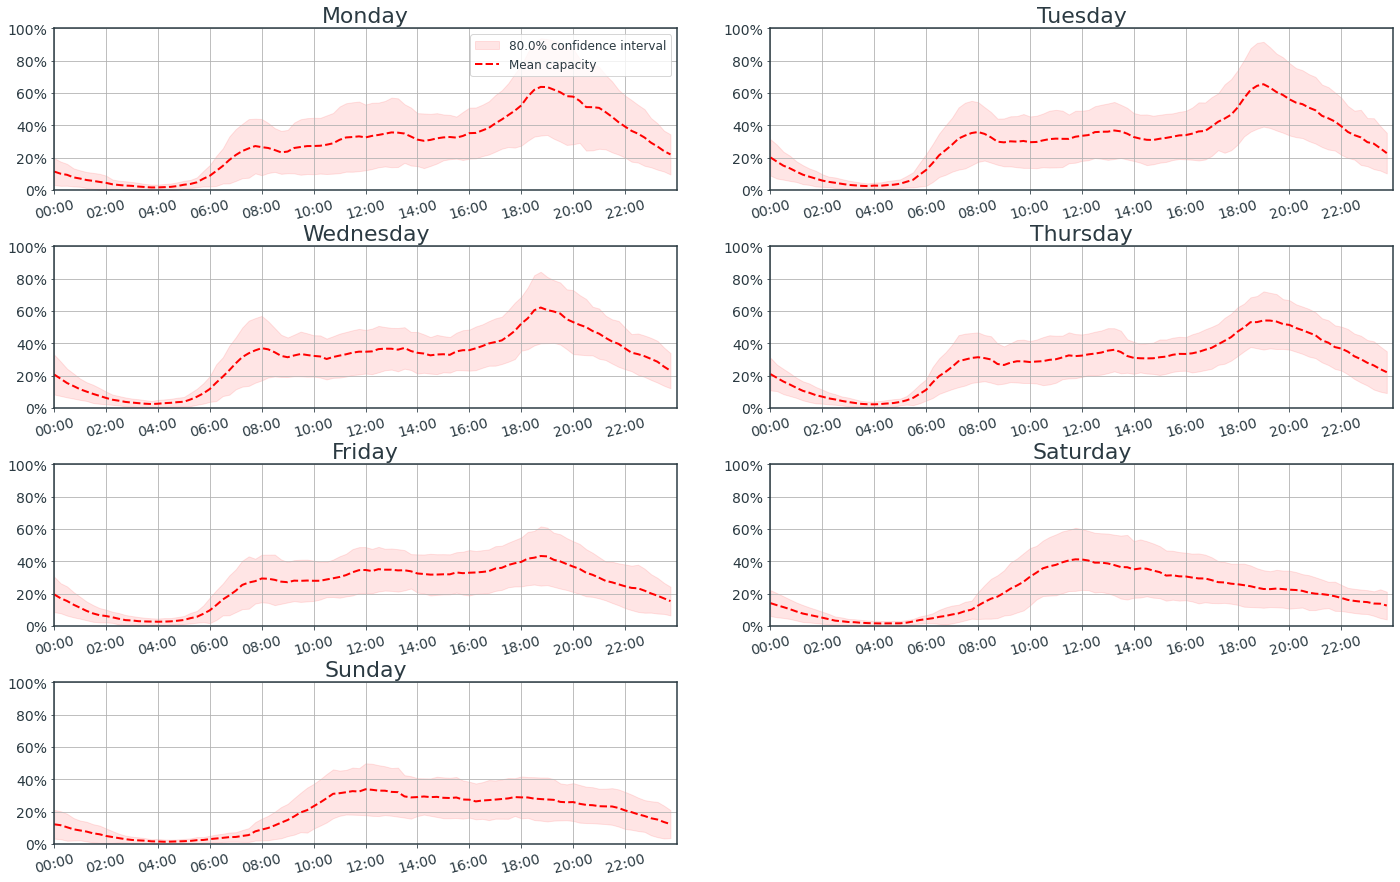

In [6]:
fig = plt.figure(figsize=(24, 15))
spec = gridspec.GridSpec(4, 2, wspace=0.15, hspace=0.35)

dft = df.copy()
dft["dow"] = dft["time"].dt.dayofweek

for i, day in enumerate(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
):
    ax = fig.add_subplot(spec[i])
    dfd = dft.query(f"dow == {i}").drop("dow", axis=1)
    plot_24h(dfd, ax=ax, ylim=100, conf_interval=0.8)
    ax.set_xlabel("")
    ax.set_title(f"{day}", y=1)
    if i != 0:
        ax.legend().remove()
    fig.add_subplot(ax)

#fig.suptitle(f"London Angel", fontsize=28, y=0.94)
#fig.savefig(ROOT_DIR / "reports" / "figures" / f"London_Angel-days_of_week.png")
fig

Comparing bank holidays with weekends reveals that they actually have very similar daily patterns, as well as very similar mean capacity trends. As such, rather than explicitly modelling bank holidays separately, we can approximate them as being weekends by labelling them this way in the data.

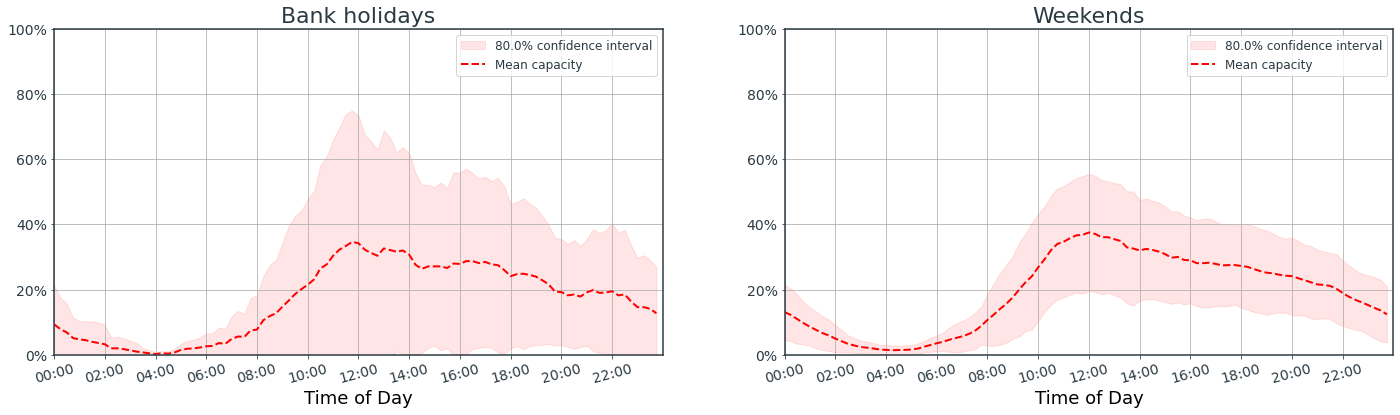

In [7]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.dayofweek > 4

df["weekday"] = ~df["time"].apply(is_weekend)
df["weekend"] = df["time"].apply(is_weekend)
df["bank_holiday"] = False
df.loc[df["time"].dt.date.astype(str).isin(uk_bank_holidays), "bank_holiday"] = True


fig, ax = plt.subplots(1, 2, figsize=(24, 6))
plot_24h(df.loc[df["bank_holiday"] == True], ax=ax[0], conf_interval=0.8)
plot_24h(df.loc[df["weekend"] == True], ax=ax[1], conf_interval=0.8)
ax[0].set_title(f"Bank holidays")
ax[1].set_title(f"Weekends")
ax[0].set_ylim(0, 100)
ax[1].set_ylim(0, 100)
fig

In [8]:
# approximate bank holidays as being equivalent to weekends
df.loc[df["time"].dt.date.astype(str).isin(uk_bank_holidays), "weekend"] = True
df.loc[df["time"].dt.date.astype(str).isin(uk_bank_holidays), "weekday"] = False
df.drop("bank_holiday", axis=1, inplace=True)

## Forecast with Prophet

[Prophet docs on 'Seasonalities that depend on other factors'](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#seasonalities-that-depend-on-other-factors
)

### Set-up

In [9]:
df["cap"] = 100  # gym capacity is bound between 0-100%
df["floor"] = 0
df = df.rename(columns={"time": "ds", "capacity": "y"})

In [10]:
if True:  # limit to most recent two months (approximately)
    df = df[-4*24*31*2:]

### Uncertainty in Seasonality - Bayesian Sampling

[Prophet docs - Uncertainty in seasonality](https://facebook.github.io/prophet/docs/uncertainty_intervals.html#uncertainty-in-seasonality)

In [11]:
m = Prophet(
    changepoint_prior_scale=0.01,  # lower = fewer changepoints
    yearly_seasonality=False,
    daily_seasonality=False,  # add manually instead for weekdays and weekends/bank holidays
    seasonality_prior_scale=20,  # higher = more fitting
    seasonality_mode="additive",
    mcmc_samples=100  # performs Bayesian Sampling for seasonality uncertainty intervals (slow)
)
m.add_seasonality(
    name="daily_weekday", period=1, fourier_order=3, condition_name="weekday"
)
m.add_seasonality(
    name="daily_weekend_or_bh", period=1, fourier_order=3, condition_name="weekend"
)
m.fit(df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
future=m.make_future_dataframe(periods=4*24*4, freq="15min")  # forecast 1 month into the future
future["weekday"] = ~future["ds"].apply(is_weekend)
future["weekend"] = future["ds"].apply(is_weekend)
future.loc[future["ds"].dt.date.astype(str).isin(uk_bank_holidays), "weekend"] = True
future.loc[future["ds"].dt.date.astype(str).isin(uk_bank_holidays), "weekday"] = False
future["cap"] = 100
future["floor"] = 0

forecast = m.predict(future)

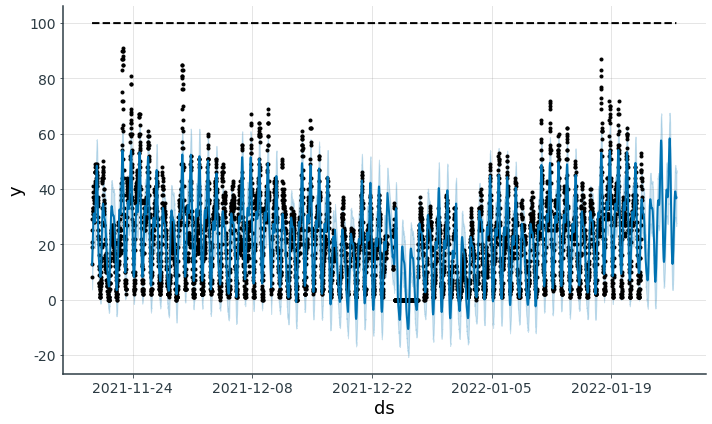

In [13]:
fig = m.plot(forecast)

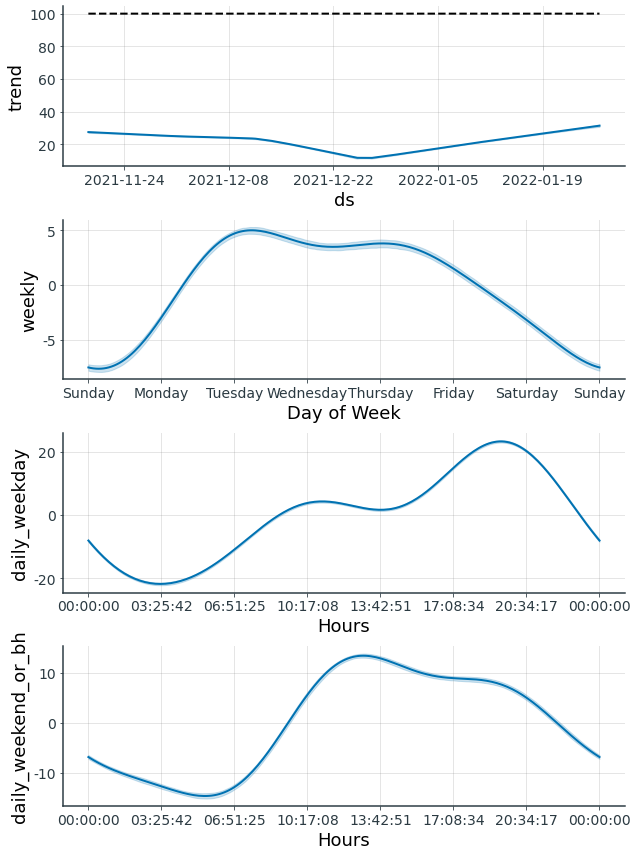

In [14]:
fig = m.plot_components(forecast)

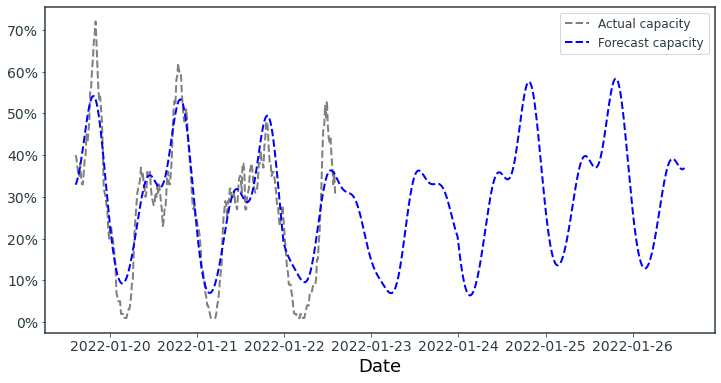

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
datetime_col = "time"
conf_interval = 0
alpha=1

# actual capacity
dfp = df.copy().rename(columns={"ds": "time", "y": "capacity"}).iloc[-24*4*3:]
ax.plot(
    dfp["time"],
    dfp["capacity"],
    c="grey",
    linestyle="--",
    label=f"Actual capacity",
)

# forecast
dff = forecast.copy().rename(columns={"ds": "time", "yhat": "capacity"}).iloc[-24*4*7:]
dff.loc[dff["capacity"] < 0, "capacity"] = 0
dff.loc[dff["capacity"] > 100, "capacity"] = 100
ax.plot(
    dff["time"],
    dff["capacity"],
    c="blue",
    linestyle="--",
    label=f"Forecast capacity",
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=False))
ax.spines[:].set_visible(True)
ax.set_xlabel("Date")
ax.legend(frameon=True)